In [15]:
#%%writefile Cointegration.py
#https://medium.com/@bart.chr/pairs-trading-for-algorithmic-trading-breakdown-d8b709f59372
#https://github.com/aconstandinou/mean-reversion

import statsmodels.api as sm
import statsmodels.tsa.stattools as ts 
from statsmodels.tsa.stattools import coint
import numpy as np
import pandas as pd
import statistics
import os.path

import matplotlib.pyplot as plt
%matplotlib inline

# Functions/Methods

In [16]:
"""
Augmented Dickey–Fuller (ADF) unit root test; p-value < .05
"""
class DickeyFuller(object):
    def __init__(self, significance=.05):
        self.significance_level = significance
        self.p_value = None
        self.perc_stat = None
        self.is_stationary = None
        
    def check(self, time_series):
        model = ts.adfuller(time_series, 1)
        self.p_value = model[1]
        statistic = model[0]
        
        # Dickey-Fuller
        self.is_stationary = False
        if (self.p_value < self.significance_level):
            self.is_stationary = True
        
        # Augmented Dickey Fuller (ADF)
        if (abs(statistic) > abs(model[4]['1%'])):
            self.perc_stat = 99
        elif (abs(statistic) > abs(model[4]['5%'])):
            self.perc_stat = 95
        elif (abs(statistic) > abs(model[4]['10%'])):
            self.perc_stat = 90
    
        return self.is_stationary

"""
Half Life test from the Ornstein-Uhlenbeck process 
"""
class HalfLife(object):
    def __init__(self):
        self.half_life = None

    def check(self, time_series):
        lag = np.roll(time_series, 1)
        lag[0] = 0
        ret = time_series - lag
        ret[0] = 0

        # adds intercept terms to X variable for regression
        lag2 = sm.add_constant(lag)
        res = sm.OLS(ret, lag2).fit()
        self.half_life = int(round(-np.log(2) / res.params[1],0))

        if self.half_life <= 0:
            self.half_life = 1
        return self.half_life

"""
If Hurst Exponent is under the 0.5 value of a random walk, then the series is mean reverting
"""
class HurstExponent():
    def __init__(self):
        self.h_min = 0.0
        self.h_max = 0.4
        self.look_back = 126
        #https://robotwealth.com/demystifying-the-hurst-exponent-part-1/
        self.lag_max = 20#era 100
        self.h_value = None
    
    def check(self, time_series):
        lags = range(2, self.lag_max)

        tau = [np.sqrt(np.std(np.subtract(time_series[lag:], time_series[:-lag]))) for lag in lags]
        poly = np.polyfit(np.log(lags), np.log(tau), 1)

        self.h_value = poly[0]*2.0 
        return self.h_value

def model_ols(y, x):
    x = sm.add_constant(x)
    model = sm.OLS(y, x).fit()
    return model

# beta/coeficiente angular
def beta(y, x):
    model = model_ols(y, x)
    return model.params[1]

"""
Check cointegrated pairs from dataframe
"""
def find_cointegrated_pairs(data, num_pairs=0, period=250):
    adf = DickeyFuller()
    rows = []
    isBreak = False
    index=-1
    
    for y_symbol in data.columns:
        index = index + 1
        for x_symbol in data.columns[index+1:data.shape[1]]:#for x_symbol in data.columns:
            if (y_symbol == x_symbol):
                continue

            # filter by period
            y, x = getvalues_by_period(data[y_symbol], data[x_symbol], period)
            
            model = model_ols(y, x)
            adf.check(model.resid)
            beta = model.params[1]
            
            # check is stationary
            if (adf.is_stationary):
                rows.append([len(x), y_symbol, x_symbol, adf.p_value, adf.perc_stat, beta])
                    
            # break for two
            isBreak = (num_pairs > 0 and len(rows) >= num_pairs)
            if (isBreak == True): break
        
        # break for one
        if (isBreak == True): break

    df_pairs = pd.DataFrame(rows, columns=['Period', 'Dependente', 'Independente', 'Dickey-Fuller', 'ADF', 'Beta'])
    return df_pairs

"""
Apply various periods in DataFrame of the pairs
"""
def apply_periods(data, pairs):
    pairs['PeriodQt'] = 0
    pairs['PeriodStr'] = ''
    for i, row in pairs.iterrows():
        y = data[row['Dependente']]
        x = data[row['Independente']]
        analysis = analysis_by_periods(y, x)
        stationary = analysis.loc[(analysis['Stationary'])]

        des = ''
        for j, row in stationary.iterrows():
            if (des!=''):
                des=des+','
            des=des+str(row['Period'])

        pairs['PeriodQt'].iloc[i] = stationary.shape[0]
        pairs['PeriodStr'].iloc[i] = des

"""
Check analysis of the periods: 100, 120, 140, 160 ... 250
"""
def analysis_by_periods(y, x):
    rows=[]
    adf = DickeyFuller()
    
    for period in [100, 120, 140, 160, 180, 200, 220, 240, 250]:
        # filter by period
        y_values, x_values = getvalues_by_period(y, x, period)

        coin = cointegration(y_values, x_values, 0)
        half_life = check_halflife(y_values, x_values)
        hurst = check_hurst(y_values, x_values)
        corr = corr_pearson(y_values, x_values)
            
        rows.append([period, coin[0], coin[1], coin[2], coin[3], half_life, hurst, corr])
        
    analysis = pd.DataFrame(rows, columns=['Period', 'Stationary', 'Dickey-Fuller', 'ADF', 'Beta', 'HalfLife', 'Hurst', 'Corr'])
    return analysis

"""
Return em log
"""
def return_varlog(time_series):
    lag = np.roll(time_series, 1)
    lag[0] = 0
    ret = np.log(time_series/lag)
    ret[0] = 0
    return ret

"""
Check cointegration in values Y vs X by period
"""
def cointegration(y, x, period = 250):
    adf = DickeyFuller()
    if (period == 0):
        period = len(y)

    y, x = getvalues_by_period(y, x, period)
    model = model_ols(y, x)
    adf.check(model.resid)
    return [adf.is_stationary, adf.p_value, adf.perc_stat, model.params[1], period]

"""
Apply half-life
"""
def apply_halflife(data, pairs, period = 250):
    pairs['HalfLife'] = 0
    
    for i, row in pairs.iterrows():
        y, x = getvalues_by_period(data[row['Dependente']], data[row['Independente']], period)
        
        value = check_halflife(y, x)
        pairs['HalfLife'].iloc[i]=value

"""
Check and return half-life
"""
def check_halflife(y, x):
    halflile = HalfLife()
    model = model_ols(y, x)
    return halflile.check(model.resid)

"""
Apply hurst coefficient
"""
def apply_hurst(data, pairs, period=250):
    pairs['Hurst'] = 0
    
    for i, row in pairs.iterrows():
        y = data[row['Dependente']]
        x = data[row['Independente']]
        y, x = getvalues_by_period(y, x, period)
            
        value = check_hurst(y, x)
        pairs['Hurst'].iloc[i]= value

"""
Check and return hurst coefficient
"""
def check_hurst(y, x):
    hurst = HurstExponent()
    model = model_ols(y, x)
    return hurst.check(model.resid.values)

# 0.9 para mais ou para menos indica uma correlação muito forte.
# 0.7 a 0.9 positivo ou negativo indica uma correlação forte.percorre
# 0.5 a 0.7 positivo ou negativo indica uma correlação moderada.
# 0.3 a 0.5 positivo ou negativo indica uma correlação fraca.
# 0 a 0.3 positivo ou negativo indica uma correlação desprezível.'''
def corr_pearson(y, x, inlog=False):
    if inlog:
        y = return_varlog(y)
        x = return_varlog(x)
    
    y_avg, x_avg = np.average(y), np.average(x)
    y_stdev, x_stdev = np.std(y), np.std(x)
    n = len(y)
    denominator = y_stdev * x_stdev * n
    numerator = np.sum(np.multiply(y-y_avg, x-x_avg))
    p_coef = numerator/denominator
    return p_coef

"""
Apply correlation in DataFrame of the pairs
"""
def apply_corr(data, pairs, period=250):
    pairs['Corr'] = 0
    
    for i, row in pairs.iterrows():
        y = data[row['Dependente']]
        x = data[row['Independente']]
        y, x = getvalues_by_period(y, x, period)
            
        corr = corr_pearson(y, x)
        pairs['Corr'].iloc[i] = corr

"""
Check signal
"""
def signal(y, x):
    model = model_ols(y, x)
    std = statistics.stdev(model.resid)
    resi_curr = model.resid.iloc[-1]
    zscore_up = 2*std
    zscore_down = -2*std
    zcurrent = 0
    desc = ''
    
    # >0; resíduo acima da linha 0
    if(resi_curr > 0):
        desc = 'Short/Long'
        zcurrent = zscore_up
    else:
        desc = 'Long/Short'
        zcurrent = zscore_down
    
    percent = (abs(resi_curr)/abs(zcurrent))
    #1-descr
    #2-resíduo atual
    #3-percent distância da linha 0, quanto maior, melhor
    return [desc, resi_curr, percent]

"""
Apply signal in DataFrame of the pairs
"""
def apply_signal(data, pairs, period=250):
    pairs['Signal'] = 0
    pairs['SignalStr'] = ''
    
    for i, row in pairs.iterrows():
        y, x = getvalues_by_period(data[row['Dependente']], data[row['Independente']], period)
        
        sig = signal(y, x)
        pairs['Signal'].iloc[i] = sig[2]
        pairs['SignalStr'].iloc[i] = sig[0]

"""
Check periods
"""
def check_periods(data, y_symbol, x_symbol, period):
    if (type(period) is int):
        return check_oneperiod(data, y_symbol, x_symbol, period)
    if (type(period) is list):
        rows=[]
        for p in period:
            res = check_oneperiod(data, y_symbol, x_symbol, p)
            rows.append([res[0], res[1]])
        return rows

"""
Check a single period
"""
def check_oneperiod(data, y_symbol, x_symbol, period):
    y, x = getvalues_by_period(data[y_symbol], data[x_symbol], period)
    
    adf = DickeyFuller()
    model = model_ols(y, x)
    adf.check(model.resid)
    beta = model.params[1]

    return [adf.p_value, adf.is_stationary]

"""
Search and return values by period
"""
def getvalues_by_period(y, x, period):
    if(period <= 0):
        return y, x
    
    n = len(y)
    if(period < n):
        pos = n-period
        y = y.iloc[pos:]
        x = x.iloc[pos:]
    return y, x

"""
Standardize by z-score
"""
def zscore(series):
    return (series - series.mean()) / np.std(series)

"""
Show graphic
"""
def show(data, y_symbol, x_symbol, period=250, padronizar=True, savefig=''):
    y, x = getvalues_by_period(data[y_symbol], data[x_symbol], period)
    
    model= model_ols(y, x)
    result = model.resid
    
    # padronizar porque a taxa absoluta pode não ser a maneira mais ideal de analisar
    if(padronizar):
        result = zscore(model.resid)
        
    std = statistics.stdev(result)
    entry_threshold = 2 # entrada em 2 desvio padrão
    
    result.plot(figsize=(15,6))
    plt.ylabel('Residual')
    plt.title(y_symbol + ' / ' + x_symbol)

    #purple
    plt.axhline(0, color='black',label='mean') # Add the mean of residual
    plt.axhline(entry_threshold*std, color='red', linestyle='--', linewidth=2)
    plt.axhline(-entry_threshold*std, color='green', linestyle='--', linewidth=2)
    
    plt.grid(True)
    if(savefig!=''):
        plt.savefig(savefig)

    #plt.legend()
    plt.show()

"""
Limpar pasta da imagem
"""
def clear_folder(pathdir):
    for file in os.listdir(pathdir):
        filename = '{}/{}.jpg'.format(pathdir, file)
        if os.path.exists(filename):
            os.remove(filename)

## Read CSV

In [5]:
path_data_cart = 'datasets/data_cart.csv'
path_data_full = 'datasets/data.csv'
path_data_alpha = 'datasets/data_alpha.csv'

In [6]:
df = pd.read_csv(path_data_cart, index_col=0)
data = df[df.columns.difference(['Data', 'Date'])]
data.shape, 'from {} to {}'.format(data.index[0], data.index[-1])

((300, 71), 'from 05/04/2019 to 19/06/2020')

In [5]:
pairs = find_cointegrated_pairs(data)
pairs.head()

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


,Period,Dependente,Independente,Dickey-Fuller,ADF,Beta
0,250,ABEV3,BBDC3,0.030399,95,0.439474
1,250,ABEV3,BBDC4,0.019617,95,0.409607
2,250,ABEV3,BBSE3,0.039490,95,0.603378
3,250,ABEV3,BRFS3,0.011584,95,0.359459
4,250,ABEV3,CIEL3,0.032895,95,1.767928


In [6]:
apply_halflife(data, pairs)
print('Half-Life applied successfully')

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


Half-Life applied successfully


In [7]:
apply_hurst(data, pairs)
print('Hurst applied successfully')

Hurst applied successfully


In [8]:
apply_corr(data, pairs)
print('Correlation applied successfully')

Correlation applied successfully


In [9]:
apply_signal(data, pairs)
print('Signal applied successfully')

Signal applied successfully


In [10]:
pairs.head(3)

,Period,Dependente,Independente,Dickey-Fuller,ADF,Beta,HalfLife,Hurst,Corr,Signal,SignalStr
0,250,ABEV3,BBDC3,0.030399,95,0.439474,12,0.406614,0.933792,0.184499,Short/Long
1,250,ABEV3,BBDC4,0.019617,95,0.409607,11,0.392145,0.934361,0.196989,Short/Long
2,250,ABEV3,BBSE3,0.039490,95,0.603378,11,0.296398,0.898245,0.223486,Long/Short


In [11]:
pairs.to_csv('datasets/cointegrated_pairs.csv', index=False)
print('Saved successfully!!!')

Saved successfully!!!


# Analysis

In [7]:
pairs = pd.read_csv('datasets/cointegrated_pairs.csv')
pairs.shape

(286, 11)

In [8]:
oper = pairs;#pairs.loc[(pairs['Hurst'] > 0) & (pairs['Hurst'] < 0.4)]
oper

,Period,Dependente,Independente,Dickey-Fuller,ADF,Beta,HalfLife,Hurst,Corr,Signal,SignalStr
0,250,ABEV3,BBDC3,0.030399,95,0.439474,12,0.406614,0.933792,0.184499,Short/Long
1,250,ABEV3,BBDC4,0.019617,95,0.409607,11,0.392145,0.934361,0.196989,Short/Long
2,250,ABEV3,BBSE3,0.039490,95,0.603378,11,0.296398,0.898245,0.223486,Long/Short
3,250,ABEV3,BRFS3,0.011584,95,0.359459,8,0.390155,0.937750,0.035288,Long/Short
4,250,ABEV3,CIEL3,0.032895,95,1.767928,7,0.344063,0.925445,0.505869,Long/Short
...,...,...,...,...,...,...,...,...,...,...,...
281,250,TAEE11,USIM5,0.026635,95,0.628566,9,0.344831,0.724486,0.408996,Short/Long
282,250,TAEE11,VIVT4,0.028677,95,0.312975,9,0.410354,0.765550,0.610944,Short/Long
283,250,TOTS3,VIVT4,0.001522,99,3.525759,6,0.266139,0.810344,1.127737,Long/Short
284,250,UGPA3,VIVT4,0.014473,95,0.792563,11,0.344271,0.773577,0.373569,Short/Long


In [9]:
#oper = oper.loc[(oper['Corr'] >= 0.70)]
#oper

#### Pares sinalizando entrada

In [19]:
signal = oper.loc[(oper['Signal'] >= 0.95)].copy()
signal.reset_index(drop=True, inplace=True)
apply_periods(data, signal)
signal.shape

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


(15, 13)

In [20]:
# somente pares cointegrados em no mínimo 3 períodos
signal = signal.loc[(signal['PeriodQt'] > 2)].sort_values(by=['HalfLife'], ascending=True).copy()
signal.reset_index(drop=True, inplace=True)
signal
#signal.to_csv('datasets/cart_oper_15062020.csv', index=False)

,Period,Dependente,Independente,Dickey-Fuller,ADF,Beta,HalfLife,Hurst,Corr,Signal,SignalStr,PeriodQt,PeriodStr
0,250,BRML3,LREN3,0.020676,95,0.415433,5,0.282369,0.968740,0.990011,Long/Short,5,"180,200,220,240,250"
1,250,CIEL3,EMBR3,0.034406,95,0.315504,6,0.259108,0.945943,1.160449,Short/Long,3,"100,120,240"
2,250,TOTS3,VIVT4,0.001522,99,3.525759,6,0.266139,0.810344,1.127737,Long/Short,6,"160,180,200,220,240,250"
3,250,IGTA3,USIM5,0.005316,99,4.294555,7,0.282449,0.938960,0.954323,Long/Short,8,"120,140,160,180,200,220,240,250"
4,250,CPFE3,SBSP3,0.023269,95,0.366542,8,0.353918,0.911026,1.127105,Long/Short,3,"220,240,250"
5,250,CYRE3,MULT3,0.023757,95,1.228802,8,0.322517,0.958869,1.524459,Short/Long,6,"160,180,200,220,240,250"
6,250,HYPE3,TOTS3,0.024007,95,0.120367,8,0.271303,0.659022,1.184556,Short/Long,5,"180,200,220,240,250"
7,250,RENT3,SBSP3,0.000918,99,0.850923,8,0.180322,0.907601,1.036100,Long/Short,9,"100,120,140,160,180,200,220,240,250"
8,250,ENGI11,SBSP3,0.017690,95,0.618690,9,0.375043,0.910820,1.021632,Long/Short,3,"220,240,250"
9,250,LREN3,SBSP3,0.044176,95,0.850664,11,0.197520,0.890170,1.511077,Long/Short,4,"160,180,240,250"


In [155]:
"""per_last = pd.read_csv('datasets/oper/17062020.csv')
per_last"""

"per_last = pd.read_csv('datasets/oper/17062020.csv')\nper_last"

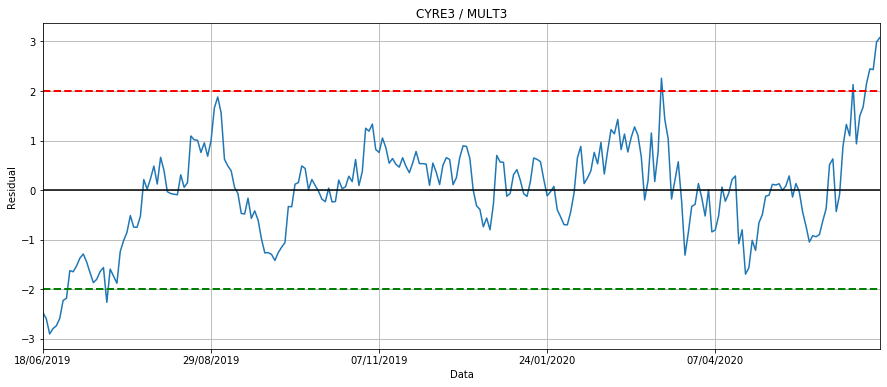

In [12]:
show(data, 'CYRE3', 'MULT3')

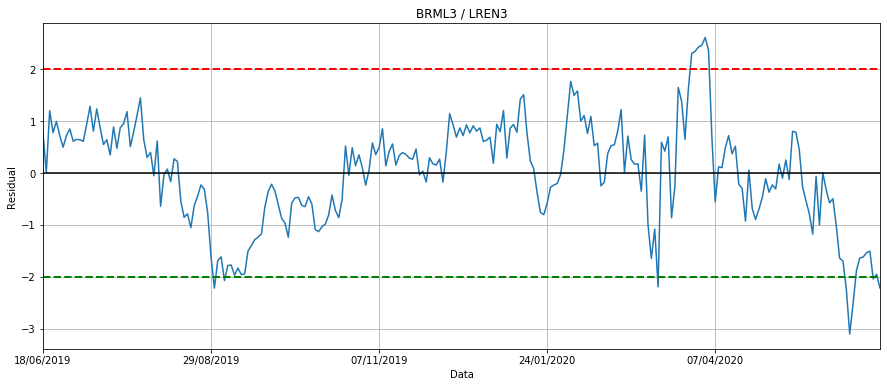

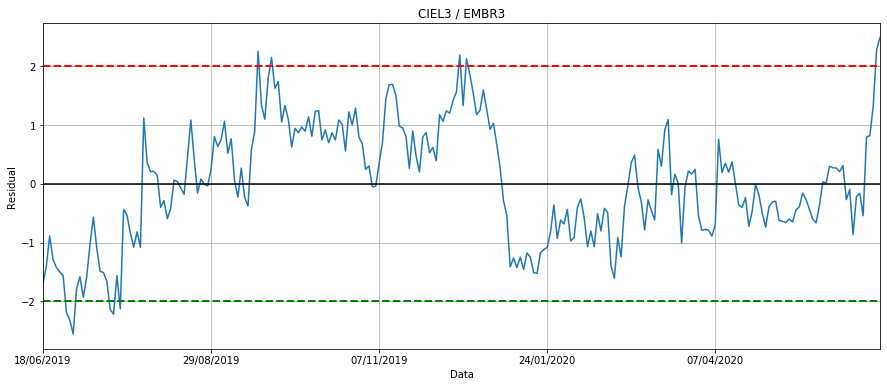

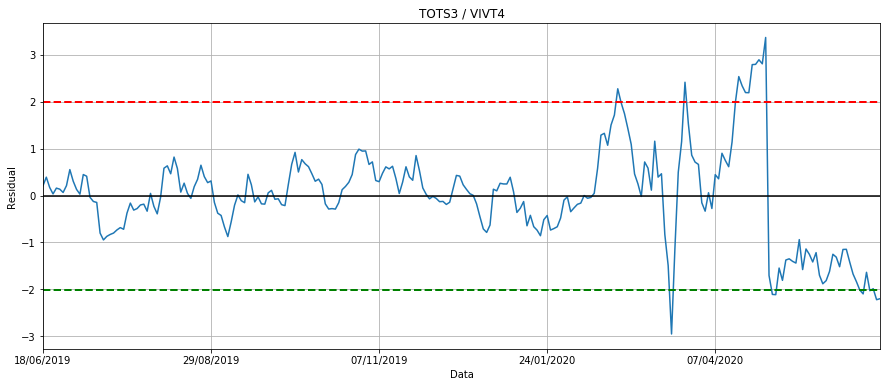

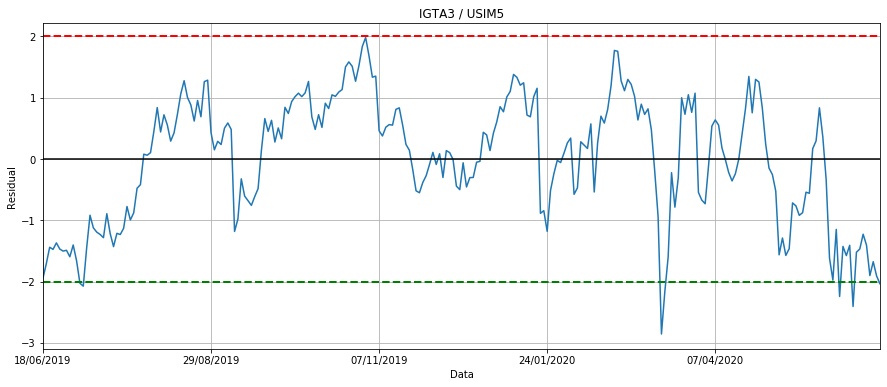

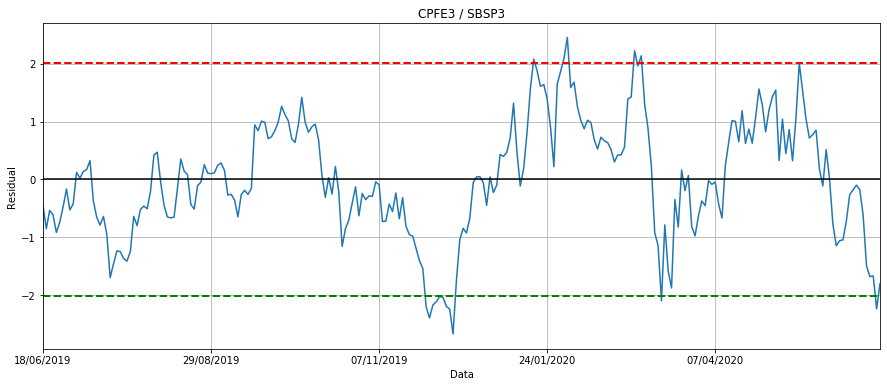

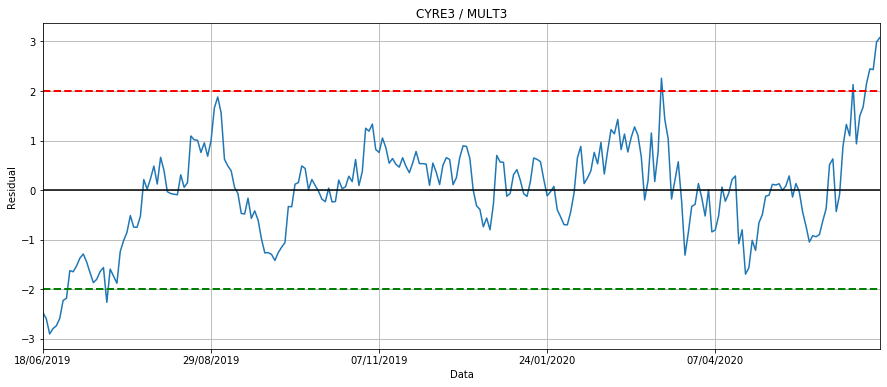

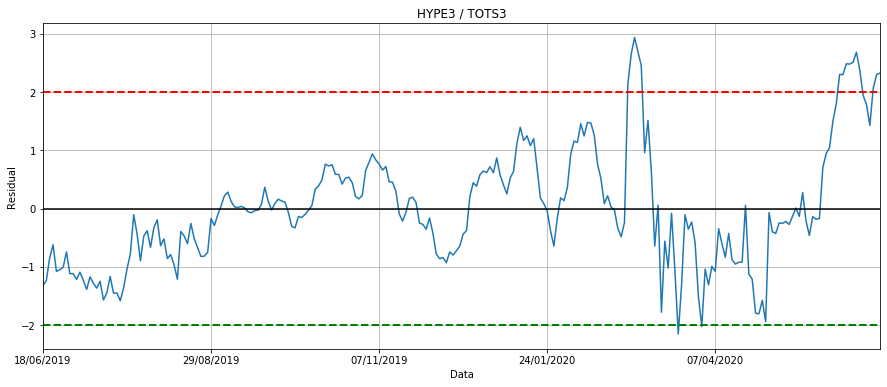

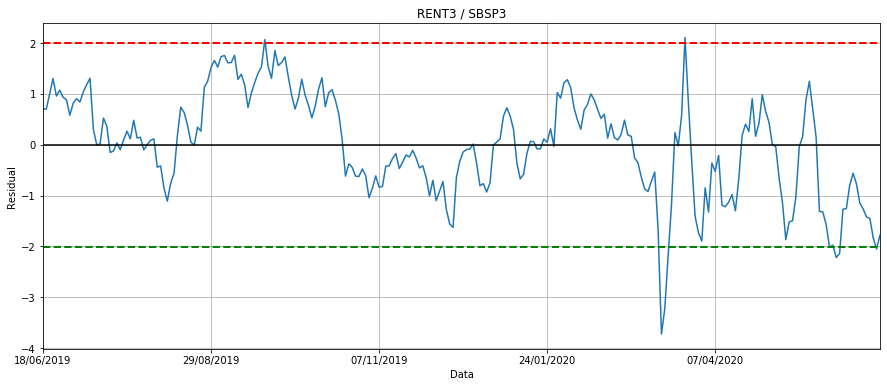

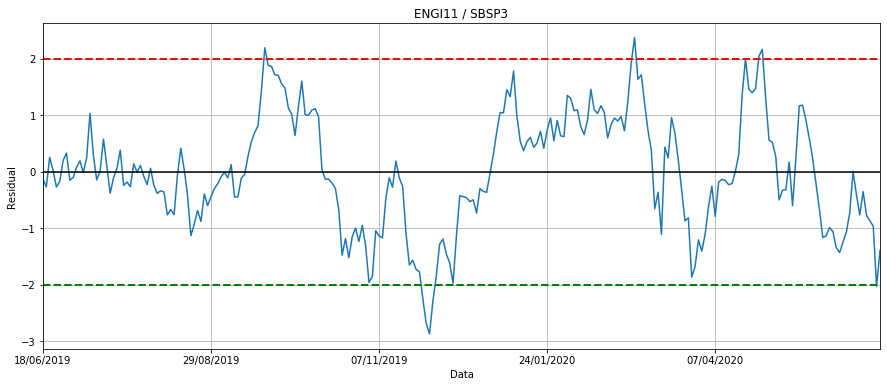

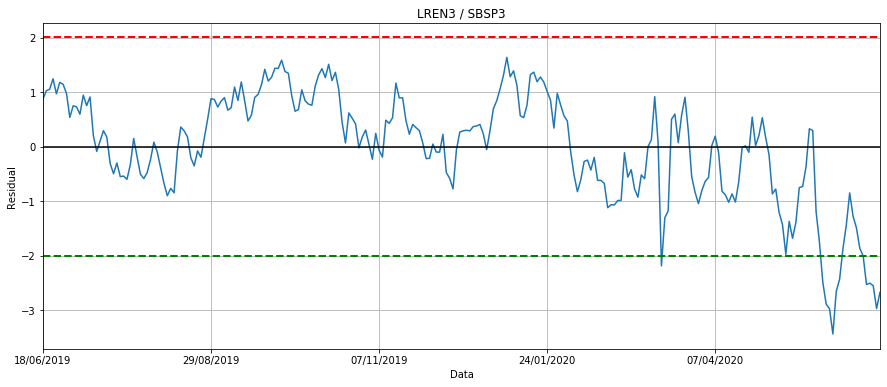

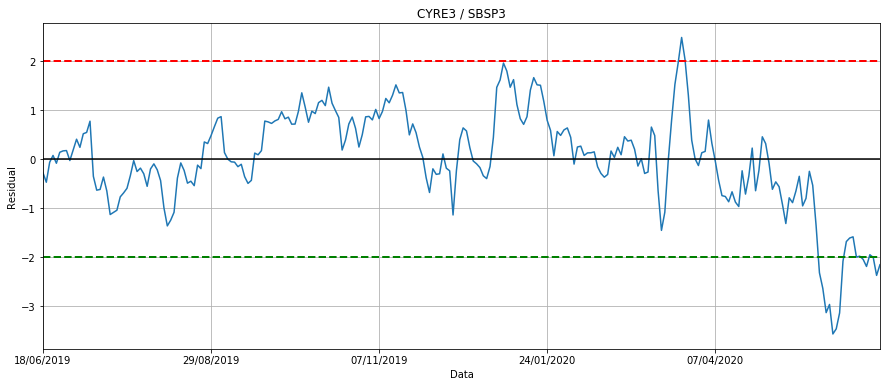

In [21]:
clear_folder('graphic')
for i, j in signal.iterrows():
    y_symbol = j['Dependente']
    x_symbol = j['Independente']
    
    show(data, y_symbol, x_symbol,padronizar=True, savefig='graphic/{}-{}.jpg'.format(y_symbol,x_symbol))